In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import os
import numpy as np


In [2]:

# Load all text files and their labels
text_data = []
labels = []
label_map = {0: 0, 2: 1, 4: 2, 6: 3, 9: 4}
reverse_label_map = {v: k for k, v in label_map.items()}



In [3]:
# Assuming 'data/ocr' is your base folder for OCR text files
base_folder = 'ML/data/ocr'
for label_folder in os.listdir(base_folder):
    label_folder_path = os.path.join(base_folder, label_folder)
    for text_file in os.listdir(label_folder_path):
        text_file_path = os.path.join(label_folder_path, text_file)
        with open(text_file_path, 'r') as file:
            text_data.append(file.read().strip())
        labels.append(label_map[int(label_folder)])

# Convert labels to a numpy array
labels = np.array(labels)

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=1000)  # You can tweak 'max_features' based on your dataset
features = vectorizer.fit_transform(text_data)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)


In [11]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

class TextClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Convert the training and test sets to PyTorch tensors
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets for the training and test sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for the training and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model
input_dim = X_train.shape[1]  # Number of features from the TfidfVectorizer
num_classes = len(label_map)  # Number of unique labels
model = TextClassifier(input_dim=input_dim, num_classes=num_classes)


In [12]:
from tqdm import tqdm

In [13]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialize a list to store loss values
epoch_losses = []

# Training loop
num_epochs = 10  # Number of epochs for training
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')
    epoch_losses.append(loss.item())

Epoch 1/10, Loss: 1.0528159141540527
Epoch 2/10, Loss: 0.6873724460601807
Epoch 3/10, Loss: 0.7422596216201782
Epoch 4/10, Loss: 0.2751014828681946
Epoch 5/10, Loss: 0.1036234200000763
Epoch 6/10, Loss: 0.09099951386451721
Epoch 7/10, Loss: 0.0776306763291359
Epoch 8/10, Loss: 0.0658046156167984
Epoch 9/10, Loss: 0.25866198539733887
Epoch 10/10, Loss: 0.03554191440343857


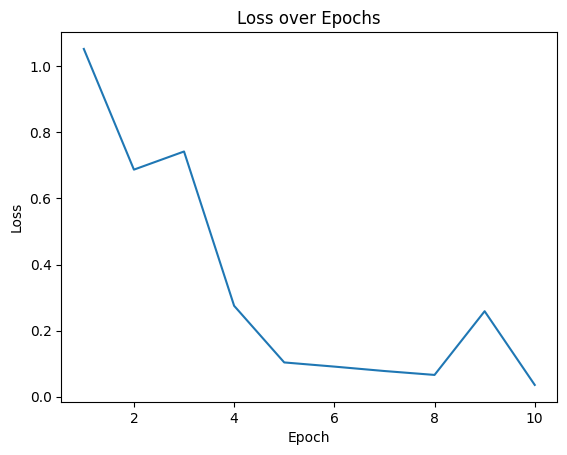

In [14]:
import matplotlib.pyplot as plt
# After training, plot the loss over epochs
plt.plot(range(1, num_epochs + 1), epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()

In [15]:
# Save the model checkpoint
torch.save(model.state_dict(), 'models/model_ocr.pth')

In [16]:

# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

true_labels, predicted_labels = evaluate_model(model, test_loader)

In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the statistics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:\n', conf_matrix)


Accuracy: 0.8380
Precision: 0.8401
Recall: 0.8380
F1 Score: 0.8371
Confusion Matrix:
 [[99  2  2  6  2]
 [ 5 78  2  0  3]
 [ 1  0 90  5 12]
 [ 0  0  2 86  5]
 [ 3  1 19 11 66]]
